# Simulating moments created by scheduler

### Imports and settings

In [2]:
import sys

sys.path.append("../")
from pulse_simulator.compiler import PulseBuilder
import pulse_simulator as ps

/Users/epelaezc/Desktop/Research/pulse-simulator/.venv/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [3]:
import numpy as np
import functools
import qiskit as qk
import qiskit_dynamics as qk_d
from qiskit.converters import circuit_to_dag, dag_to_circuit
import qiskit.providers.fake_provider as qk_fp

In [4]:
# configure jax to use 64 bit mode
import jax

jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")

# set default backend
qk_d.array.Array.set_default_backend("jax")
qk_d.array.Array.default_backend()

'jax'

In [5]:
# Set the parameters globally for the model
N = 4  # number of spins
hz = 1.0 * 2 * np.pi  # magnetic field along z
Jx = 1.0 * 2 * np.pi  # Coupling along x
Δt = 0.05  # time step for integration
tlist = np.arange(50) * Δt  # time values

# Global backend
backend = qk_fp.FakeManila()

In [6]:
units = 1e9
GHz = 1 / units
ns = units

dt = backend.configuration().dt * ns
duration = 220 * dt  # ns

### Circuit generating functions

In [7]:
def create_initial_state(qr, cr):
    """
    Creates the initial state for the experiment.
    Here we would like to prepare the |+>|+>|+>|+> state.
    """
    circ = qk.QuantumCircuit(qr, cr)
    [circ.h(qr[i]) for i in range(qr.size)]
    return circ


def rxx(circ, θx, q1, q2):
    """
    Implements the exp(-i theta/2 sx_1 sx_2) gate.
    """
    circ.cx(q1, q2)
    circ.rx(θx, q1)
    circ.cx(q1, q2)
    return circ


def first_order_Trotter_unitary(circ, Δt, barrier=False):
    """
    Applies a Unitary for a single time step U(Δt) using first-order trotter expansion to the input quantum circuit.
    input : circ is a quantum circuit
    output : circ-U(Δt)-
    """
    # Layer A: coupling XX between n and n+1
    # Induce parallel CR gates
    if barrier:
        circ.barrier()
    for p in range(0, circ.num_qubits - 1, 2):
        circ = rxx(circ, Jx * Δt, circ.qubits[p], circ.qubits[p + 1])
    if barrier:
        circ.barrier()
    for p in range(1, circ.num_qubits - 1, 2):
        circ = rxx(circ, Jx * Δt, circ.qubits[p], circ.qubits[p + 1])

    #  Alt., a naive loop will apply XX rotations sequentially, failing to stack.
    # for p in range(0, circ.num_qubits - 1):
    #     circ = rxx(circ, Jx * Δt, circ.qubits[p], circ.qubits[p + 1])

    # Layer B: on-site Z
    for p in range(circ.num_qubits):
        circ.rz(hz * Δt, circ.qubits[p])

    return circ


def second_order_Trotter_unitary(circ, Δt):
    """
    Applies a Unitary for a single time step U(Δt) using second-order trotter expansion to the input quantum circuit.
    input : circ is a quantum circuit
    output : circ-U(Δt)-
    """
    # Layer 2: on-site Z (half)
    for p in range(circ.num_qubits):
        circ.rz(hz * Δt / 2, circ.qubits[p])

    # Layer 1: coupling XX between n and n+1
    # Induce parallel structure (and symmetry)
    for p in range(1, circ.num_qubits - 1, 2):
        circ = rxx(circ, Jx * Δt / 2, circ.qubits[p], circ.qubits[p + 1])
    # NOTE: Add barriers to separate the parallel section
    circ.barrier()
    for p in range(0, circ.num_qubits - 1, 2):
        circ = rxx(circ, Jx * Δt, circ.qubits[p], circ.qubits[p + 1])
    circ.barrier()
    for p in range(1, circ.num_qubits - 1, 2):
        circ = rxx(circ, Jx * Δt / 2, circ.qubits[p], circ.qubits[p + 1])

    # Layer 2: on-site Z (half)
    for p in range(circ.num_qubits):
        circ.rz(hz * Δt / 2, circ.qubits[p])
    return circ

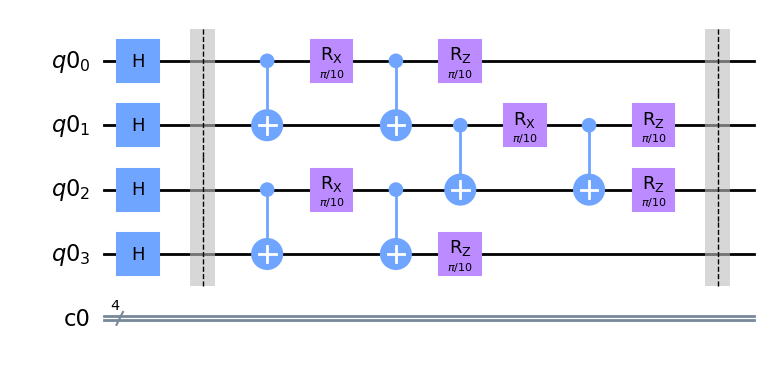

In [8]:
qr = qk.QuantumRegister(N)
cr = qk.ClassicalRegister(N)
circ = create_initial_state(qr, cr)
circ.barrier()
circ = first_order_Trotter_unitary(circ, Δt)
circ.barrier()
circ.draw("mpl", style="clifford")

### Pulse generating functions

In [9]:
def gaussian(x, mu=0, sigma=1):
    return np.exp(-((x - mu) ** 2) / 2 / sigma**2)


def lifted_gaussian(x, mu, sigma, x0=-1):
    g = functools.partial(gaussian, mu=mu, sigma=sigma)
    return (g(x) - g(x0)) / (1 - g(x0))


def truncated_gaussian(x, mu=0, sigma=1):
    g = functools.partial(gaussian, mu=mu, sigma=sigma)
    return g(x) - g(0)


def gaussian_envelope(dt, duration, angle=np.pi):
    """Define gaussian envelope function to accumulate the angle.

    Returns:
        Qiskit pulse implementing angle.
    """
    steps = int(duration / dt)

    # Arbitrary shape
    # NOTE: Qiskit doesn't like pulse amplitudes > 1. Widen to avoid this.
    sigma = steps / 4
    mu = steps / 2

    # Normalize
    x = np.linspace(0, steps, endpoint=True)
    area = np.trapz(lifted_gaussian(x, mu, sigma), x)
    amplitude = angle / area / dt

    # Adjust the amplitude to achieve the angle
    return qk.pulse.Gaussian(steps, amplitude, sigma)


def zero_envelope(dt, duration):
    steps = int(duration / dt)
    return qk.pulse.Constant(steps, 0.0)

### Sample pulse dictionaries

In [10]:
one_q_pulses = {
    "sx_red": gaussian_envelope(dt, duration, angle=np.pi / 4),
    "sx_blue": gaussian_envelope(dt, duration, angle=np.pi / 4),
    "x_red": gaussian_envelope(dt, duration, angle=np.pi / 2),
    "x_blue": gaussian_envelope(dt, duration, angle=np.pi / 2),
}

In [11]:
control_pulses = {
    "rzx_red": gaussian_envelope(dt, duration, angle=np.pi / 2),
    "rzx_blue": gaussian_envelope(dt, duration, angle=np.pi / 2),
}

target_pulses = {
    "rzx_red": zero_envelope(dt, duration),
    "rzx_blue": zero_envelope(dt, duration),
}

In [12]:
basis_gates = ["rz", "x", "sx", "rzx", "id"]
pb = PulseBuilder(
    basis_gates=basis_gates,
    coupling_map=None,
    one_q_pulses=one_q_pulses,
    control_pulses=control_pulses,
    target_pulses=target_pulses,
    backend=backend,
)

In [13]:
pulses = pb.build(circ)

### One-qubit moment simulation

In [23]:
test_pulse = pulses[0]
test_circuit = dag_to_circuit(list(circuit_to_dag(circ).layers())[0]["graph"])
print(test_circuit)

      ┌───┐
q0_0: ┤ H ├
      ├───┤
q0_1: ┤ H ├
      ├───┤
q0_2: ┤ H ├
      ├───┤
q0_3: ┤ H ├
      └───┘
c0: 4/═════
           


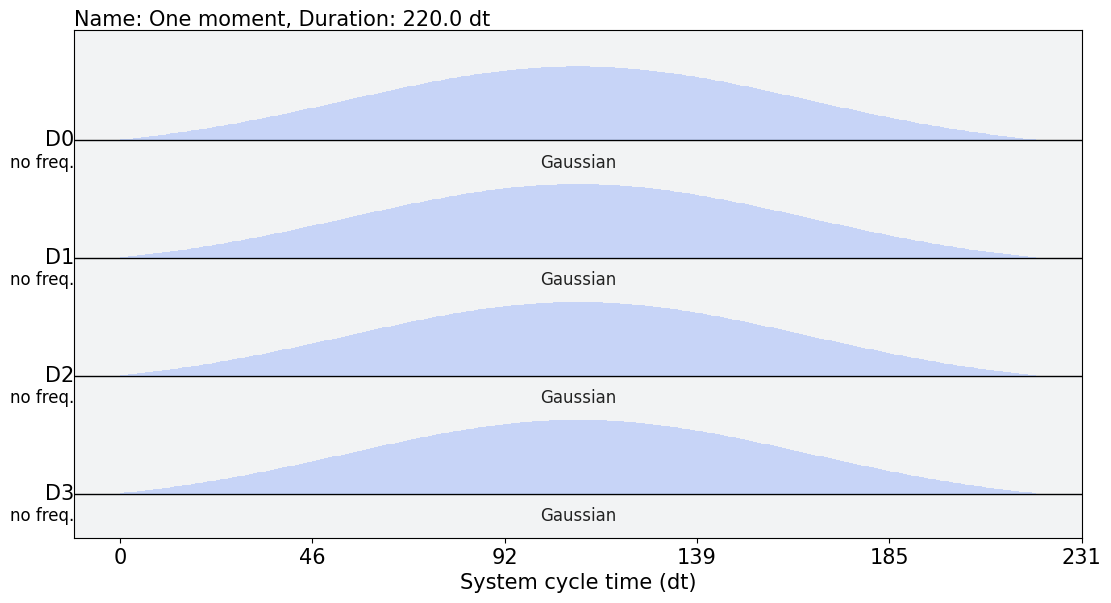

In [24]:
test_pulse.draw()

In [16]:
registers = [0, 1, 2, 3]
config_vars = ps.backend_simulation_vars(backend, rabi=False, units=units)

# Define models fixed by the current parameters
# =====
H_rx = functools.partial(
    ps.rx_model,
    registers=registers,
    backend=backend,
    variables=config_vars,
    rotating_frame=False,
)

A_decay = functools.partial(
    ps.qubit_decay_model, registers=registers, variables=config_vars
)


H_xtalk = ps.crosstalk_model(registers, ps.backend_edges(backend), config_vars)

# Create a system model
# =====
# Control model
#   Single qubit circuit moment: attach RX models to each qubit
H_drift = 0.0
Hs_control = []
Hs_channels = []
As_static = []
for qubit in range(4):
    # if qubit_index in registers:
    Hj_drift, Hjs_control, Hjs_channel = H_rx(qubit)

    # NOTE: doesn't work with quantum channel simulator yet
    Ajs_static = A_decay(qubit)

    H_drift += Hj_drift
    Hs_control += Hjs_control
    Hs_channels += Hjs_channel
    As_static += Ajs_static


# Construct the solver
# NOTE: no rotating frames for now
# =====
solver = qk_d.Solver(
    static_hamiltonian=H_xtalk,
    hamiltonian_operators=Hs_control,
    static_dissipators=None,
    rotating_frame=None,
    rwa_cutoff_freq=None,
    hamiltonian_channels=Hs_channels,
    channel_carrier_freqs={ch: 0.0 for ch in Hs_channels},
    dt=dt,
)

In [17]:
# Start the qubit in its ground state.
y0 = ps.qiskit_ground_state(len(registers))

virtual_zs = {0: -np.pi / 2, 1: -np.pi / 2, 2: -np.pi / 2, 3: -np.pi / 2}

# Manual Z gates (no pulses)
Vz = ps.rz_moment(virtual_zs, registers)
y0 = y0.evolve(Vz)

# Identity matrix
U0 = ps.qiskit_identity_operator(len(registers))

# NOTE: Unsure if correct
# Identity channel
C0 = qk.quantum_info.SuperOp(U0)

In [18]:
solver.model.evaluation_mode = "sparse"
sol = solver.solve(
    t_span=[0.0, duration],
    y0=U0,
    signals=test_pulse,
    atol=1e-8,
    rtol=1e-8,
    method="jax_odeint",
)

sol1 = solver.solve(
    t_span=[0.0, duration],
    y0=y0,
    signals=test_pulse,
    atol=1e-8,
    rtol=1e-8,
    method="jax_odeint",
)

In [19]:
basis = ps.hilbert_space_basis([2] * len(registers))

# Check final states
yf1 = sol1.y[-1]
y_after_1qb_moment = yf1

Uf = sol.y[-1]
yf = y0.evolve(Uf)

# Compare
print(f"Are equal? {yf1 == yf}\n")
print(f"Are close? ||y1 - y2|| = {np.linalg.norm(yf1 - yf)}\n")

# States
ps.print_wavefunction(yf, basis, tol=1e-3)
print()

# ps.print_wavefunction(yf1, basis)

Are equal? True

Are close? ||y1 - y2|| = 3.214631127319757e-06

-0.25-0.00j |0000>
-0.00+0.25j |0001>
-0.00+0.25j |0010>
+0.25+0.00j |0011>
-0.00+0.25j |0100>
+0.25-0.00j |0101>
+0.25+0.00j |0110>
+0.00-0.25j |0111>
-0.00+0.25j |1000>
+0.25+0.00j |1001>
+0.25-0.00j |1010>
+0.00-0.25j |1011>
+0.25+0.00j |1100>
+0.00-0.25j |1101>
+0.00-0.25j |1110>
-0.25-0.00j |1111>

